In [6]:
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy.engine import URL

# connexion à Neon via .env
load_dotenv()

url = URL.create(
    drivername="postgresql+psycopg2",
    username=os.getenv("NEON_USER"),
    password=os.getenv("NEON_PASSWORD"),
    host=os.getenv("NEON_HOST"),
    port=int(os.getenv("NEON_PORT", "5432")),
    database=os.getenv("NEON_DB"),
    query={"sslmode": os.getenv("NEON_SSLMODE", "require")},
)

engine = create_engine(url, pool_pre_ping=True)

# petit test de connexion
test_df = pd.read_sql("SELECT now() AS now, version() AS version;", engine)
print(test_df)

# charger les tables nécessaires depuis Neon
fact_env = pd.read_sql("""
    SELECT country_key,
           year,
           coal_consumption,
           gas_consumption,
           oil_consumption
    FROM fact_energy_environment;
""", engine)

fact_soc = pd.read_sql("""
    SELECT country_key,
           year,
           gdp
    FROM fact_socio_economy;
""", engine)

dim_country = pd.read_sql("""
    SELECT country_key,
           country_name,
           iso_code
    FROM dim_country;
""", engine)


                               now  \
0 2025-12-17 13:55:06.745224+00:00   

                                             version  
0  PostgreSQL 17.7 (bdc8956) on aarch64-unknown-l...  


Idée : apprendre sur l’historique comment le GDP réagit aux consommations d’énergies fossiles, puis simuler des scénarios où ces consommations baissent de 2, 3 ou 4 % par an

In [7]:
# top 10 GDP pour l'année 2020
soc_2020 = fact_soc[
    (fact_soc["year"] == 2020) & fact_soc["gdp"].notna()
]

top10_2020 = (
    soc_2020
    .nlargest(10, "gdp")
    .merge(
        dim_country[["country_key", "country_name", "iso_code"]],
        on="country_key",
        how="left"
    )
)

print(top10_2020[["country_name", "iso_code", "gdp"]])


     country_name iso_code           gdp
0           China      CHN  2.415184e+13
1   United States      USA  1.802736e+13
2           India      IND  8.945313e+12
3           Japan      JPN  4.626661e+12
4         Germany      DEU  3.742721e+12
5          Russia      RUS  3.606717e+12
6       Indonesia      IDN  3.204973e+12
7          Brazil      BRA  2.950377e+12
8          France      FRA  2.438594e+12
9  United Kingdom      GBR  2.334804e+12


In [ ]:
def build_country_scenarios(
    country_key: int,
    start_year: int = 2020,
    end_year: int = 2025,
    rates=(0.02, 0.03, 0.04),
):
    """
    Construit les scénarios de GDP pour un pays donné.

    Retourne :
      - hist : DataFrame avec l'historique de GDP (2010 → start_year)
               colonnes : ["year", "gdp"]
      - scenarios : dict {label_scenario: DataFrame}
        où chaque DataFrame a les colonnes ["year", "gdp_pred"]
    """

    # fusionner socio + energy pour avoir GDP et consommations ensemble
    df = (
        fact_soc[fact_soc["country_key"] == country_key]
        .merge(
            fact_env[
                [
                    "country_key",
                    "year",
                    "coal_consumption",
                    "gas_consumption",
                    "oil_consumption",
                ]
            ],
            on=["country_key", "year"], ##on garde uniquement les années où on a à la fois GDP et énergie pour ce pays
            how="inner",
        )
    )

    # nettoyage : retirer les lignes incomplètes
    df_clean = df[
        [
            "year",
            "gdp",
            "coal_consumption",
            "gas_consumption",
            "oil_consumption",
        ]
    ].dropna() ## on enlève les lignes avec des NaN dans les colonnes utilisées

    if df_clean.empty:
        raise ValueError(f"Pas assez de données complètes pour country_key={country_key}")

    df_clean = df_clean.sort_values("year")

    # régression linéaire OLS : GDP ~ coal + gas + oil
    X = df_clean[["coal_consumption", "gas_consumption", "oil_consumption"]].values
    y = df_clean["gdp"].values

    X_design = np.c_[np.ones(len(X)), X]  # ajout de l'intercept
    beta, *_ = np.linalg.lstsq(X_design, y, rcond=None)

    def predict_gdp(coal, gas, oil):        
        x = np.array([1, coal, gas, oil])
        return float(x @ beta)
##J’entraîne une régression linéaire qui apprend des coefficients : combien le GDP varie en fonction des consommations de charbon, gaz et pétrol
# Ensuite j’encapsule cette relation dans une fonction predict_gdp qui me permet de prédire un GDP à partir de n’importe quel triplet (charbon, gaz, pétrole)

    # récupérer la ligne de référence pour start_year (ex : 2020)
    row_2020 = df_clean[df_clean["year"] == start_year]
    if row_2020.empty:
        raise ValueError(
            f"Pas de données énergie + gdp pour {start_year} (country_key={country_key})"
        )
    row_2020 = row_2020.iloc[0]

    coal_0 = row_2020["coal_consumption"]
    gas_0 = row_2020["gas_consumption"]
    oil_0 = row_2020["oil_consumption"]
    gdp_real_2020 = row_2020["gdp"]

    # offset pour recalibrer les courbes pour qu’elles partent exactement du GDP réel 2020
    # offset = l’écart entre le GDP réel 2020 et le GDP que le modèle prédit pour 2020
    gdp_pred_2020 = predict_gdp(coal_0, gas_0, oil_0)
    offset = gdp_real_2020 - gdp_pred_2020

    years = list(range(start_year, end_year + 1))
    scenarios = {}

    # construire les scénarios pour chaque taux de baisse en bouclant: chaque année on multiplie par (1 - rate)
    for rate in rates:
        label = f"-{int(rate * 100)}% par an"
        coal = coal_0
        gas = gas_0
        oil = oil_0

        rows = []

        for i, year in enumerate(years):
            if i > 0:
                # baisse des consommations de 'rate' chaque année
                coal *= (1 - rate)
                gas *= (1 - rate)
                oil *= (1 - rate)

            gdp_pred = predict_gdp(coal, gas, oil)
            # on recale pour que 2020 du scénario colle au GDP réel
            gdp_pred_aligned = gdp_pred + offset

            rows.append({"year": year, "gdp_pred": gdp_pred_aligned})

        scenarios[label] = pd.DataFrame(rows)

    # hist = pour tracer la courbe bleue : le GDP reel 2010–2020
    hist = df_clean[
        (df_clean["year"] >= 2010) & (df_clean["year"] <= start_year)
    ][["year", "gdp"]].copy()

    return hist, scenarios


In [18]:
def plot_country_scenarios(country_key):
    # retrouver le nom du pays
    row_country = dim_country[dim_country["country_key"] == country_key].iloc[0]
    name = row_country["country_name"]
    iso = row_country["iso_code"]

    hist, scenarios = build_country_scenarios(country_key)

    plt.figure(figsize=(8, 5))

    # courbe historique
    plt.plot(hist["year"], hist["gdp"], marker="o", label="GDP réel")

    # courbes de scénarios
    for label, sdf in scenarios.items():
        plt.plot(
            sdf["year"],
            sdf["gdp_pred"],
            marker="o",
            linestyle="--",
            label=f"Scénario {label}"
        )

    plt.xlabel("Année")
    plt.ylabel("GDP")
    plt.title(f"Scénarios de GDP pour {name} ({iso})")
    plt.legend()
    plt.tight_layout()
    plt.show()


=== China (CHN) ===


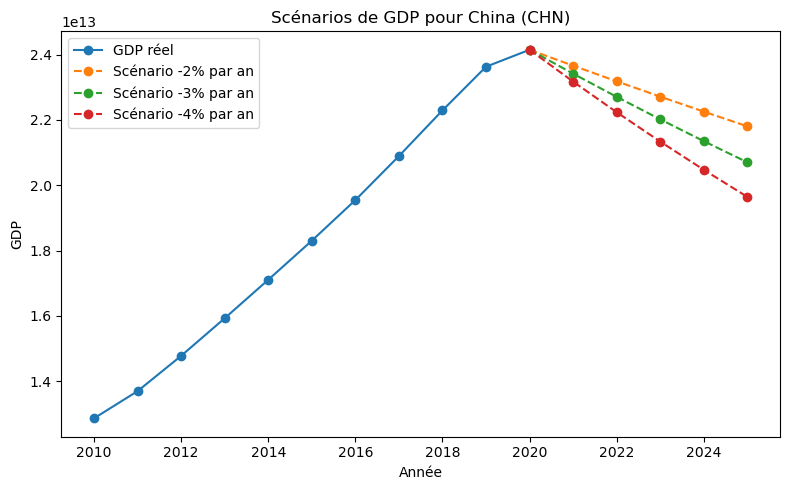

=== United States (USA) ===


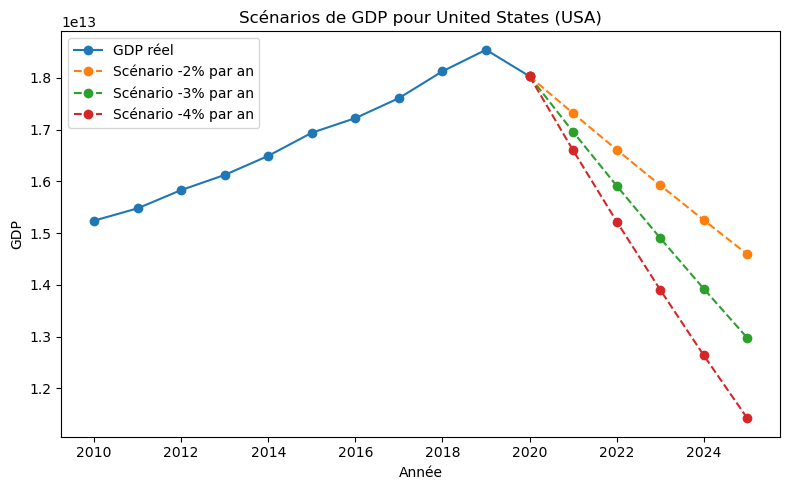

=== India (IND) ===


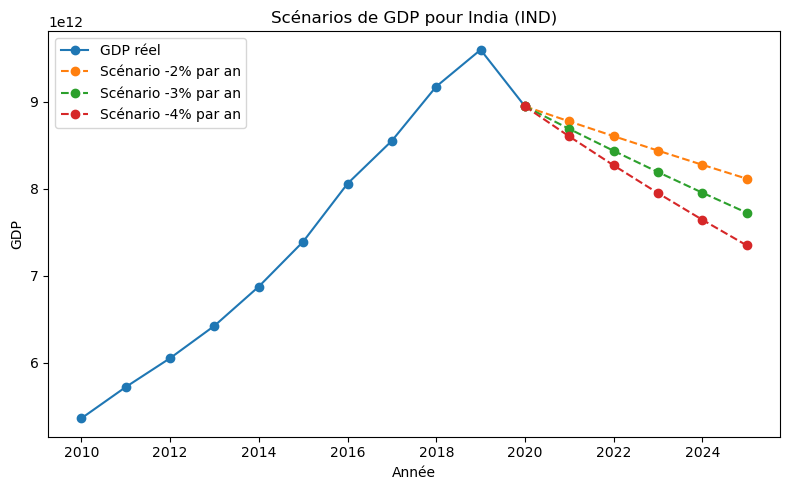

=== Japan (JPN) ===


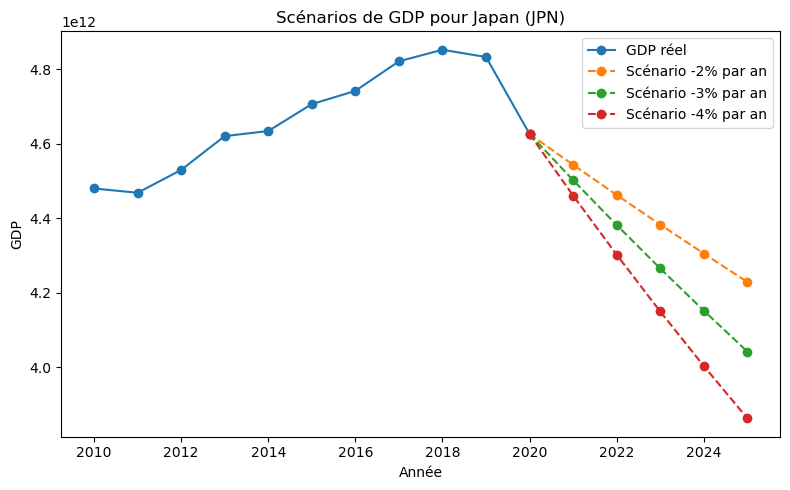

=== Germany (DEU) ===


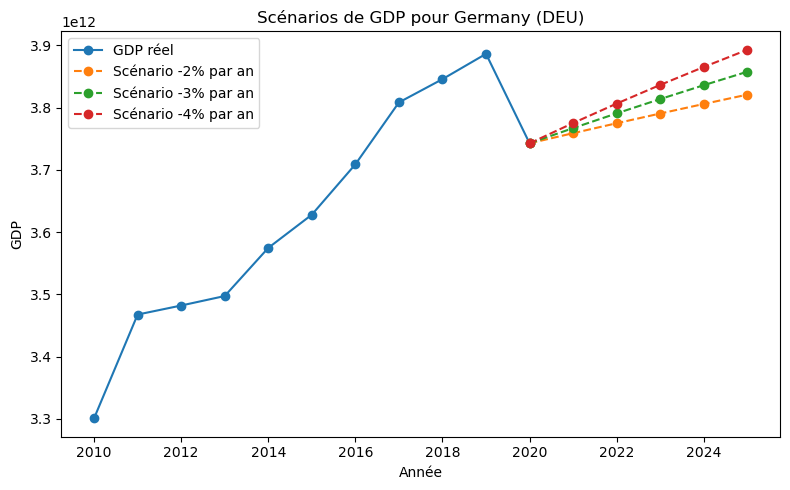

=== Russia (RUS) ===


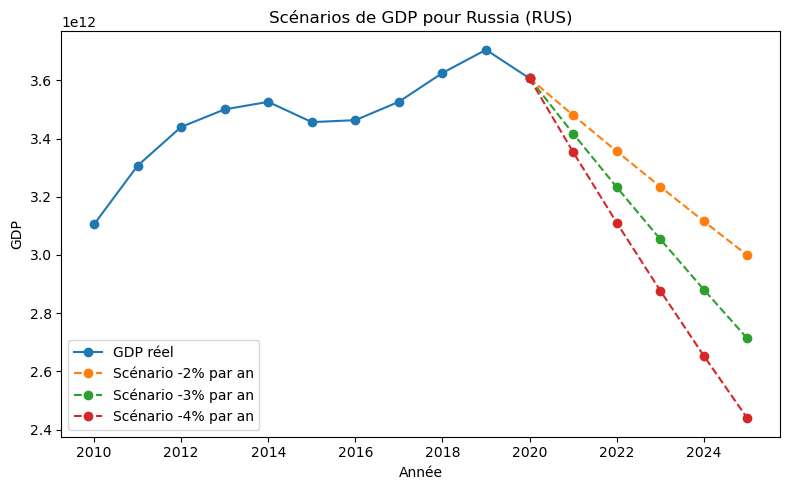

=== Indonesia (IDN) ===


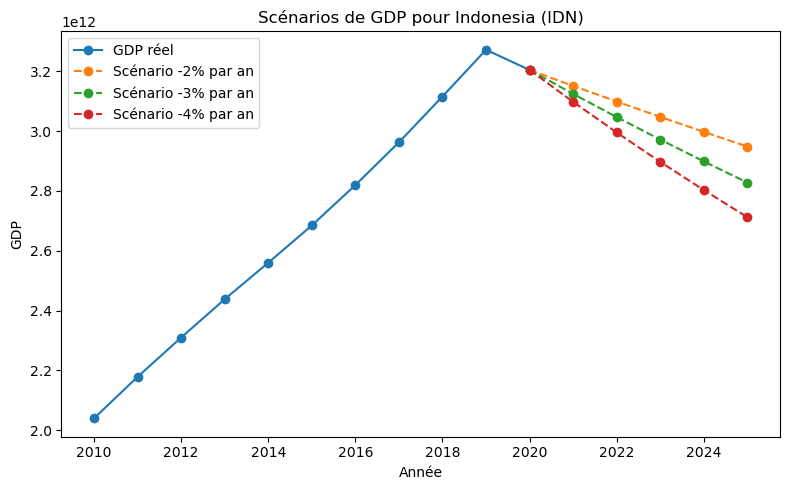

=== Brazil (BRA) ===


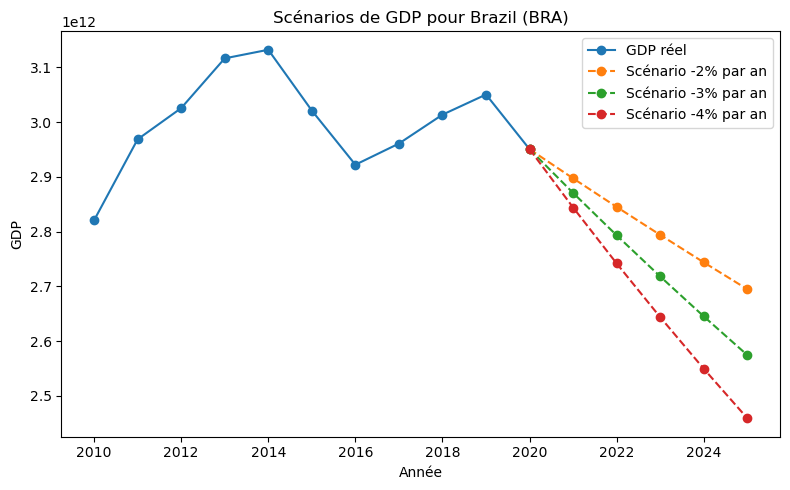

=== France (FRA) ===


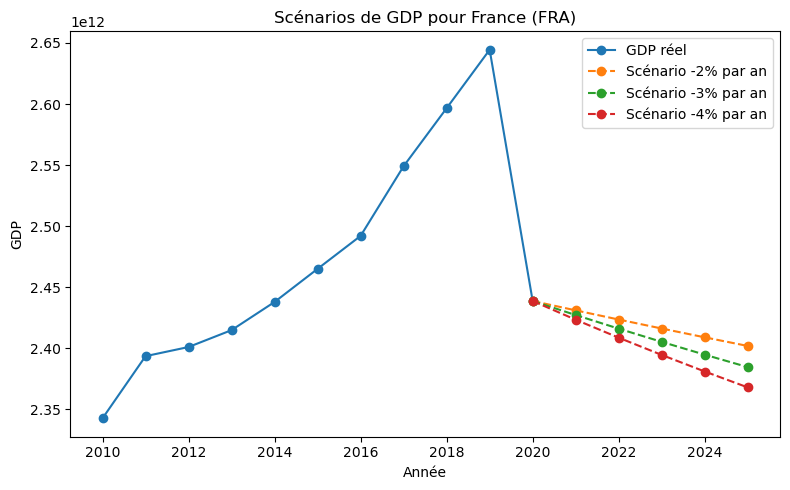

=== United Kingdom (GBR) ===


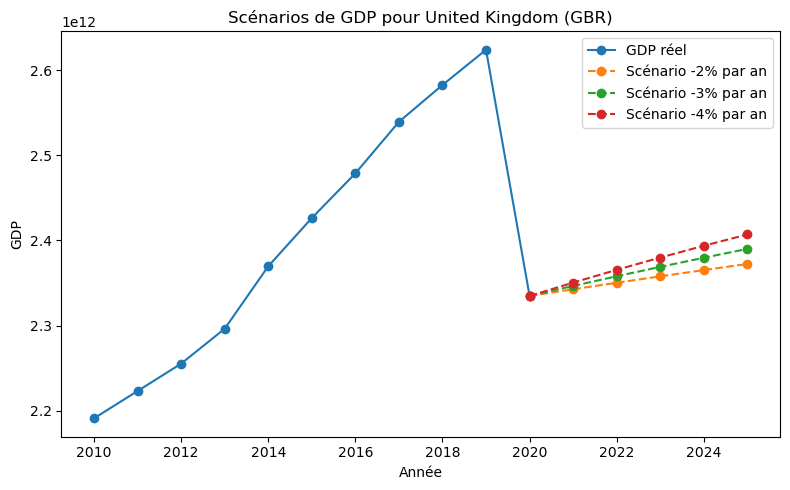

In [19]:
for _, row in top10_2020.iterrows():
    ck = row["country_key"]
    print(f"=== {row['country_name']} ({row['iso_code']}) ===")
    plot_country_scenarios(ck)


Matrice de corrélation globale :
                  coal_consumption  gas_consumption  oil_consumption
coal_consumption          1.000000         0.427054         0.631207
gas_consumption           0.427054         1.000000         0.874810
oil_consumption           0.631207         0.874810         1.000000


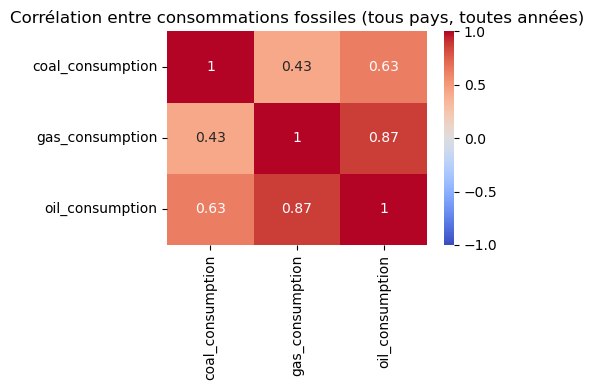

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sélection des colonnes énergie
energy_cols = ["coal_consumption", "gas_consumption", "oil_consumption"]

df_energy = fact_env[energy_cols].dropna()

# Matrice de corrélation
corr_matrix = df_energy.corr()
print("Matrice de corrélation globale :")
print(corr_matrix)

# Heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1, cmap="coolwarm")
plt.title("Corrélation entre consommations fossiles (tous pays, toutes années)")
plt.tight_layout()
plt.show()


In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Colonnes énergie
energy_cols = ["coal_consumption", "gas_consumption", "oil_consumption"]

# Filtrer sur les 10 pays au plus haut GDP
top10_keys = top10_2020["country_key"].unique()

df_energy_top10 = (
    fact_env[fact_env["country_key"].isin(top10_keys)][energy_cols]
    .dropna()
)

print("Aperçu df_energy_top10 :")
print(df_energy_top10.head())
print("Shape :", df_energy_top10.shape)



Aperçu df_energy_top10 :
      coal_consumption  gas_consumption  oil_consumption
1439         20.178049         0.513422       177.730576
1440         21.864399         0.600403       193.797592
1441         22.597090         0.678716       199.991730
1442         22.236561         0.717290       240.196152
1443         24.818420         0.755965       263.567719
Shape : (580, 3)


In [23]:
# Matrice X pour le VIF
X = df_energy_top10[energy_cols].values

vif_data = []
for i, col in enumerate(energy_cols):
    vif = variance_inflation_factor(X, i)
    vif_data.append({"variable": col, "VIF": vif})

vif_df = pd.DataFrame(vif_data)
print("\nVIF sur les consommations fossiles (top 10 pays) :")
print(vif_df)



VIF sur les consommations fossiles (top 10 pays) :
           variable       VIF
0  coal_consumption  2.061845
1   gas_consumption  5.877694
2   oil_consumption  8.142776
